# Assumptions of Linear Regression

## Imports and connection

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn import linear_model

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

In [2]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

weather_df = pd.read_sql_query('select * from weatherinszeged',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

## Understanding the Data

In [3]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   date                 96453 non-null  datetime64[ns, UTC]
 1   summary              96453 non-null  object             
 2   preciptype           96453 non-null  object             
 3   temperature          96453 non-null  float64            
 4   apparenttemperature  96453 non-null  float64            
 5   humidity             96453 non-null  float64            
 6   windspeed            96453 non-null  float64            
 7   windbearing          96453 non-null  float64            
 8   visibility           96453 non-null  float64            
 9   loudcover            96453 non-null  float64            
 10  pressure             96453 non-null  float64            
 11  dailysummary         96453 non-null  object             
dtypes: datetime64[ns, 

In [4]:
weather_df.head()

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


## Testing assumptions

### Assumption one: the regression model is linear in parameters

In [5]:
# Y is the target variable
Y = weather_df['temperature']

# X is the feature set
X = weather_df[['humidity', 'windspeed', 'windbearing', 'pressure']]

# Using scikit-learn to create a linear regression object
lrm = linear_model.LinearRegression()

lrm.fit(X, Y)

predictions = lrm.predict(X)
errors = np.array(Y) - predictions

print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)

# Assuming that my Y is a linear combination of my Xs, AKA coefficient not squared.


Coefficients: 
 [-3.24962454e+01 -2.01413742e-01  4.04836936e-03 -6.91759209e-04]

Intercept: 
 37.92643818528537


### Assumption two: the error term should be zero on average

In [6]:
print('The mean of errors in the medical costs model is: {}'.format(np.mean(errors)))

The mean of errors in the medical costs model is: 1.2823995048481462e-15


### Assumption three: homoscedasticity

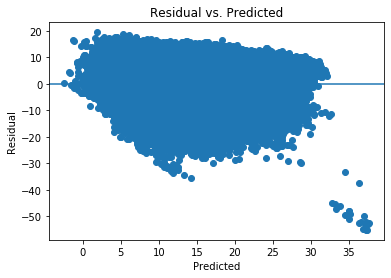

In [7]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [8]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print('Bartlett test statistic value is {0:3g} and p value is {1:.3g}'.format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 2464.84 and p value is 0
Levene test statistic value is 2321.24 and p value is 0


Based on the p-values above, we can reject the null hypothesis, concluding that our model shows heteroscedasticity. Thus, the accuracy of out parameters are not reliable.

### Assumption four: low multicollinearity

In [9]:
X.corr()

,humidity,windspeed,windbearing,pressure
humidity,1.000000,-0.224951,0.000735,0.005454
windspeed,-0.224951,1.000000,0.103822,-0.049263
windbearing,0.000735,0.103822,1.000000,-0.011651
pressure,0.005454,-0.049263,-0.011651,1.000000


Correlation seems to be low except between humitiy and windspeed, with -0.22.

### Assumption five: error terms should be uncorrelated with one other

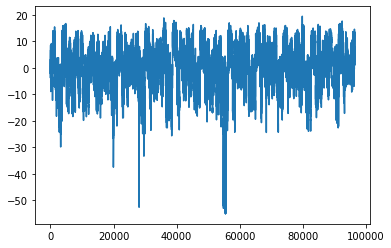

In [10]:
plt.plot(errors)
plt.show()

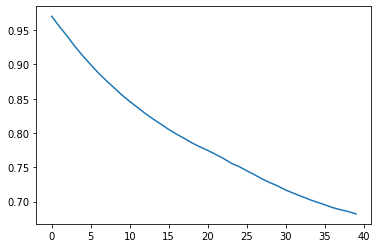

In [11]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

Errors would seem to be serially correlated. Because the weather from the previous day is highly correlated with the weather today (time-series nature of the data). Our model can't explain the temperature very well and hence it suffers from the ommitted variable. **However, since the dataset involves very limited number of features, fixing this issue is not trivial.(?)**

### Assumption six: features shouldn't be correlated with the errors

In [12]:
df = pd.concat([X, pd.DataFrame(errors, columns=["error"])], axis=1)
df.corr().iloc[:,:]
# Why -1?

,humidity,windspeed,windbearing,pressure,error
humidity,1.000000e+00,-2.249515e-01,7.346454e-04,5.454263e-03,-1.759645e-15
windspeed,-2.249515e-01,1.000000e+00,1.038215e-01,-4.926281e-02,6.014286e-16
windbearing,7.346454e-04,1.038215e-01,1.000000e+00,-1.165088e-02,1.697506e-16
pressure,5.454263e-03,-4.926281e-02,-1.165088e-02,1.000000e+00,-3.187374e-16
error,-1.759645e-15,6.014286e-16,1.697506e-16,-3.187374e-16,1.000000e+00


In [13]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 3793.296735252356 and p value is 0.0
Normality test statistics is 3375.4323076995797 and p value is 0.0


Normality tests indicate that the errors of the model are not distributed normally. This implies that the test statistics for the coefficients are problematic.

# Exercise 2: House Prices

## Imports and connection

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn import linear_model

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [15]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_prices_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [16]:
house_prices_df = pd.concat([house_prices_df,pd.get_dummies(house_prices_df.mszoning, prefix="mszoning", drop_first=True)], axis=1)

house_prices_df = pd.concat([house_prices_df,pd.get_dummies(house_prices_df.street, prefix="street", drop_first=True)], axis=1)

dummy_column_names = list(pd.get_dummies(house_prices_df.mszoning, prefix="mszoning", drop_first=True).columns)

dummy_column_names = dummy_column_names + list(pd.get_dummies(house_prices_df.street, prefix="street", drop_first=True).columns)

In [17]:
# Y is the target variable
Y = house_prices_df['saleprice']
# X is the feature set
X = house_prices_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf'] + dummy_column_names]

# We create a LinearRegression model object from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

predictions = lrm.predict(X)
errors = np.array(Y) - predictions

# Estimated coefficients.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [2.33265353e+04 4.56343565e+01 1.34501364e+04 1.64082048e+01
 2.83816393e+01 2.50875137e+04 1.34204564e+04 2.85658560e+04
 9.04778936e+03 1.51037622e+02]

Intercept: 
 -117337.72871399307


### Assumption two: the error term should be zero on average

In [18]:
print("Mean of the errors in the medical costs model is: {}".format(np.mean(errors)))

Mean of the errors in the medical costs model is: -2.3602010452584045e-11


The average error is quite close to zero so we can assume that it is zero.

### Assumption three: homoscedasticity

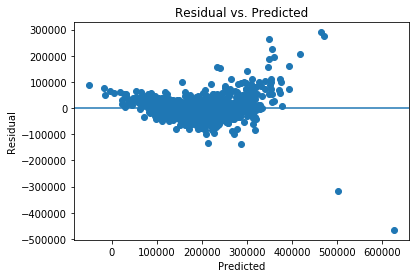

In [19]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [20]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 497.754 and p value is 2.93e-110
Levene test statistic value is 491.982 and p value is 7.29e-101


Both the chart and the test statistics indicate that our model suffers from heteroscedasticity. This implies that the accuracies of our estimations are not reliable.

### Assumption four: low multicollinearity

In [21]:
X.corr()

,overallqual,grlivarea,garagecars,garagearea,totalbsmtsf,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,street_Pave
overallqual,1.000000,0.593007,0.600671,0.562022,0.537808,0.171854,-0.064666,0.126972,-0.195515,0.058823
grlivarea,0.593007,1.000000,0.467247,0.468997,0.454868,0.024275,-0.001070,0.132936,-0.154239,0.044121
garagecars,0.600671,0.467247,1.000000,0.882475,0.434585,0.102851,-0.090477,0.175167,-0.221834,-0.020025
garagearea,0.562022,0.468997,0.882475,1.000000,0.486665,0.114859,-0.073188,0.169593,-0.235580,-0.047794
totalbsmtsf,0.537808,0.454868,0.434585,0.486665,1.000000,-0.032689,-0.055128,0.257373,-0.247379,0.005068
mszoning_FV,0.171854,0.024275,0.102851,0.114859,-0.032689,1.000000,-0.022722,-0.416608,-0.090435,0.013866
mszoning_RH,-0.064666,-0.001070,-0.090477,-0.073188,-0.055128,-0.022722,1.000000,-0.203158,-0.044101,0.006762
mszoning_RL,0.126972,0.132936,0.175167,0.169593,0.257373,-0.416608,-0.203158,1.000000,-0.808585,0.045348
mszoning_RM,-0.195515,-0.154239,-0.221834,-0.235580,-0.247379,-0.090435,-0.044101,-0.808585,1.000000,-0.003127
street_Pave,0.058823,0.044121,-0.020025,-0.047794,0.005068,0.013866,0.006762,0.045348,-0.003127,1.000000


We have some highly correlated features like garagearea and garagecars. We can solve this issue by dropping one of the strongly correlated variables from the model.

### Assumption five: error terms should be uncorrelated with one other

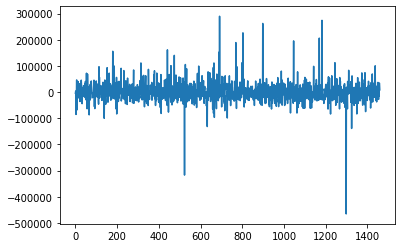

In [22]:
plt.plot(errors)
plt.show()

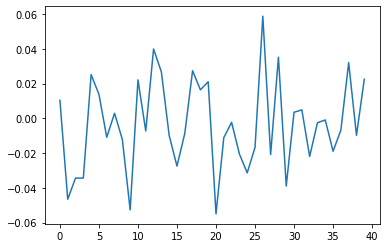

In [23]:
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

The charts above indicate that the error terms are uncorrelated with each other.

### Assumption six: features shouldn't be correlated with the errors

In [24]:
df = pd.concat([X, pd.DataFrame(errors, columns=["error"])], axis=1)
df.corr().iloc[:,-1:]

,error
overallqual,2.388760e-14
grlivarea,-5.505231e-15
garagecars,7.271032e-14
garagearea,9.187250e-14
totalbsmtsf,3.315897e-15
mszoning_FV,1.591622e-14
mszoning_RH,-7.032284e-15
mszoning_RL,5.234689e-15
mszoning_RM,-1.385942e-14
street_Pave,-9.167723e-15


As evidenced in the table above, the features and the errors are uncorrelated.

In [25]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 41281.526018265184 and p value is 0.0
Normality test statistics is 415.8826568586275 and p value is 4.922984898072417e-91


Normality tests indicate that the errors of the model are not distributed normally. This implies that the test statistics for the coefficients are problematic.